In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time

# set cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# calculate meand and std for normalization
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=5000, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean.numpy(), std.numpy()

In [3]:
# calculate mean and std calculation to train and test datasets
train_dataset_for_stats = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor())
test_dataset_for_stats = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())
train_mean, train_std = calculate_mean_std(train_dataset_for_stats)
test_mean, test_std = calculate_mean_std(test_dataset_for_stats)
print(f"Train Mean: {train_mean}, Train Std: {train_std}")
print(f"Test Mean: {test_mean}, Test Std: {test_std}")

Train Mean: [0.49139968 0.4821584  0.44653094], Train Std: [0.20230092 0.19941281 0.2009616 ]
Test Mean: [0.49421427 0.48513138 0.45040908], Test Std: [0.20199348 0.19911824 0.20113055]


In [4]:
# data loading, preprocessing, transforms sesuai paper
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    transforms.RandomRotation(degrees=10),   # random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # random brightness and contrast
    transforms.ToTensor(),                   # convert to tensor and scale to [0,1]
    transforms.Normalize(train_mean, train_std)  # normalize using mean and std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
# CNN model arch. (sesuai paper)
class CNNImageClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNImageClassifier, self).__init__()
        
        # first convolutional layer (C1)
        # input: 32x32x3, Kernel: 3x3, Stride: 3, Padding: 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=3, padding=1)
        
        # first pooling layer (S1) - Max pooling 2x2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # second convolutional layer (C2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3, padding=1)
        
        # second pooling layer (S2) - Max pooling 2x2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # calculate the size after convolution and pooling operations
        # after conv1: (32-3+2*1)/3 + 1 = 11 (bulatkaan ke bawah)
        # after pool1: 11/2 = 5 (bulatkaan ke bawah)
        # after conv2: (5-3+2*1)/3 + 1 = 2 (bulatkaan ke bawah)
        # after pool2: 2/2 = 1
        # final feature map size is 1x1x64
        
        # 3 fully connected layers (Fc1, Fc2, Fc3)
        self.fc1 = nn.Linear(64 * 1 * 1, 128)  # 1 
        self.fc2 = nn.Linear(128, 64)          # 2 
        self.fc3 = nn.Linear(64, num_classes)  # 3  (output layer)
        
        # dropout for regularization (sesuai paper)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # first convolutional block: Conv1 + ReLU + Pool1
        x = self.pool1(F.relu(self.conv1(x)))
        
        # second convolutional block: Conv2 + ReLU + Pool2
        x = self.pool2(F.relu(self.conv2(x)))
        
        # flatten for fully connected layers
        x = x.view(-1, 64 * 1 * 1)
        
        # first fully connected layer + ReLU + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # second fully connected layer + ReLU + Dropout
        x = self.dropout(F.relu(self.fc2(x)))
        
        # tshird fully connected layer (output layer) - no activation here
        # softmax will be applied in the loss function
        x = self.fc3(x)
        
        return x

# init model
model = CNNImageClassifier(num_classes=10).to(device)

# cek architecture
print("Model Architecture:")
print(model)

# count parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
CNNImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 36,618
Trainable parameters: 36,618


In [6]:
# loss function - Cross Entropy (sudaha termasuk Softmax)
criterion = nn.CrossEntropyLoss()

# optimizer - SGD with momentum (sesuai info pada paper)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# learning rate scheduler (for better convergence)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# training parameters (sesuai paper)
num_epochs = 20      
num_iterations = 5   # iterations set to 5 as mentioned in paper
                     # sebenarnya agak bingung juga, karena di paper tidak dijelaskan maksudnya apa

print(f"Training configuration:")
print(f"- Epochs: {num_epochs}")
print(f"- Learning rate: 0.01")
print(f"- Optimizer: SGD with momentum (0.9)")
print(f"- Loss function: Cross Entropy")
print(f"- Device: {device}")

# store list training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

Training configuration:
- Epochs: 20
- Learning rate: 0.01
- Optimizer: SGD with momentum (0.9)
- Loss function: Cross Entropy
- Device: cuda


In [7]:
# train and test functions (per epoch); train loop utama ada dibawah
def train_one_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # count statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # cetaak progress tiap 100 batch
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(trainloader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# define test function
def test_model(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# define function to evaluate class-wise accuracy
def evaluate_class_accuracy(model, testloader, device, classes):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    class_accuracies = {}
    for i in range(10):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        class_accuracies[classes[i]] = accuracy
        print(f'{classes[i]}: {accuracy:.1f}%')
    
    return class_accuracies

In [8]:
# training loop
print("Train start...")
start_time = time.time()

best_test_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print('-' * 50)
    
    # call train function
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
    
    # call test function
    test_loss, test_acc = test_model(model, testloader, criterion, device)
    
    # save history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_state = model.state_dict().copy()
    
    # update learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Best Test Acc: {best_test_acc:.2f}%')

# load best model
model.load_state_dict(best_model_state)

training_time = time.time() - start_time
print(f'\nTraining completed in {training_time:.2f} seconds')
print(f'Best test accuracy: {best_test_acc:.2f}%')

# save the trained model
torch.save(model.state_dict(), 'cnn_cifar10_model.pth')
print("Model saved as 'cnn_cifar10_model.pth'")

Train start...

Epoch [1/20]
--------------------------------------------------
Batch [0/782], Loss: 2.3209, Acc: 9.38%
Batch [100/782], Loss: 2.2676, Acc: 10.86%
Batch [200/782], Loss: 2.0894, Acc: 13.74%
Batch [300/782], Loss: 1.9360, Acc: 16.32%
Batch [400/782], Loss: 1.8926, Acc: 18.49%
Batch [500/782], Loss: 1.8656, Acc: 20.19%
Batch [600/782], Loss: 1.7863, Acc: 21.47%
Batch [700/782], Loss: 1.7761, Acc: 22.70%
Train Loss: 2.0127, Train Acc: 23.54%
Test Loss: 1.7026, Test Acc: 36.20%
Best Test Acc: 36.20%

Epoch [2/20]
--------------------------------------------------
Batch [0/782], Loss: 1.7874, Acc: 29.69%
Batch [100/782], Loss: 1.8925, Acc: 32.46%
Batch [200/782], Loss: 1.8504, Acc: 32.66%
Batch [300/782], Loss: 1.8191, Acc: 33.57%
Batch [400/782], Loss: 1.5260, Acc: 34.18%
Batch [500/782], Loss: 1.7283, Acc: 34.92%
Batch [600/782], Loss: 1.6498, Acc: 35.37%
Batch [700/782], Loss: 1.6986, Acc: 35.82%
Train Loss: 1.7127, Train Acc: 36.27%
Test Loss: 1.4734, Test Acc: 46.20%
Be


Class-wise accuracy:
plane: 66.3%
car: 73.2%
bird: 36.2%
cat: 38.5%
deer: 41.7%
dog: 58.5%
frog: 68.9%
horse: 69.0%
ship: 76.2%
truck: 71.2%


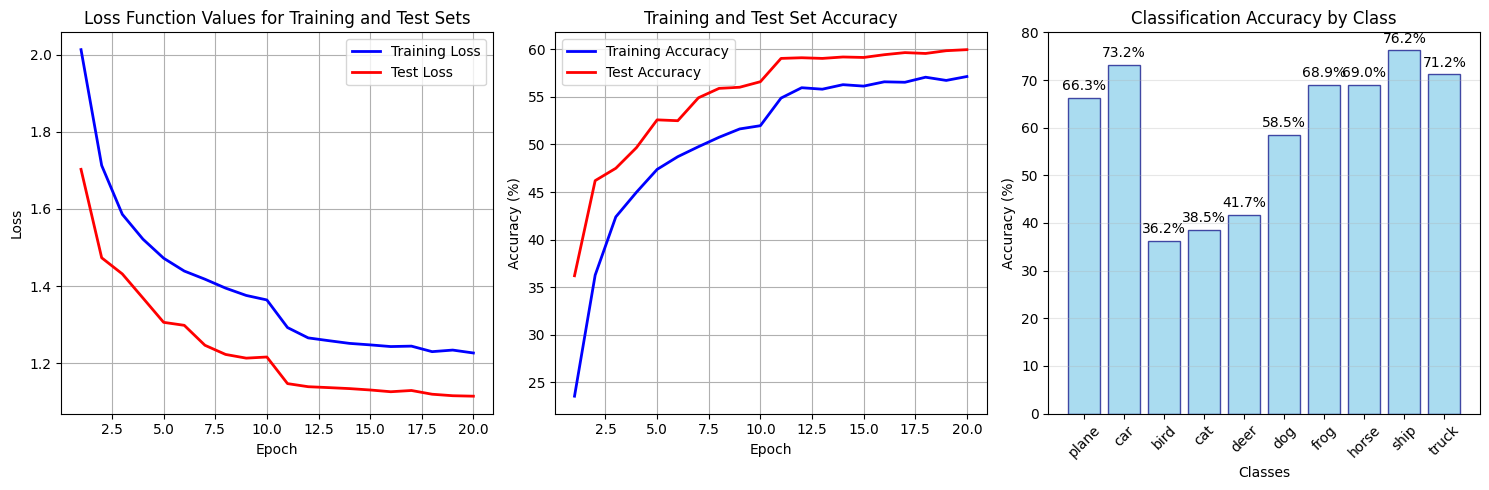


--------------------------------------------------
FINAL RESULTS SUMMARY
--------------------------------------------------
Overall Test Accuracy: 60.0%
Training Time: 318.69 seconds

Class-wise Accuracy:
   plane:  66.3%
     car:  73.2%
    bird:  36.2%
     cat:  38.5%
    deer:  41.7%
     dog:  58.5%
    frog:  68.9%
   horse:  69.0%
    ship:  76.2%
   truck:  71.2%

Average Class Accuracy: 60.0%


In [9]:
# results visualization and analysis
# plot training history
plt.figure(figsize=(15, 5))

# plot loss curves
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function Values for Training and Test Sets')
plt.legend()
plt.grid(True)

# plot accuracy curves
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Set Accuracy')
plt.legend()
plt.grid(True)

# plot class-wise accuracy
plt.subplot(1, 3, 3)
print("\nClass-wise accuracy:")
class_accs = evaluate_class_accuracy(model, testloader, device, classes)

class_names = list(class_accs.keys())
accuracies = list(class_accs.values())

plt.bar(class_names, accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy by Class')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# add accuracy labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# print final results summary
print(f"\n" + "-"*50)
print("FINAL RESULTS SUMMARY")
print("-"*50)
print(f"Overall Test Accuracy: {best_test_acc:.1f}%")
print(f"Training Time: {training_time:.2f} seconds")
print("\nClass-wise Accuracy:")
for class_name, acc in class_accs.items():
    print(f"{class_name:>8}: {acc:>5.1f}%")

# calculate average accuracy
avg_accuracy = np.mean(list(class_accs.values()))
print(f"\nAverage Class Accuracy: {avg_accuracy:.1f}%")

In [10]:
# Comparison with SVM and KNN (as mentioned in the paper)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def prepare_data_for_sklearn(trainloader, testloader, n_samples=5000):
    print("Preparing data for SVM and KNN comparison...")
    
    # separate features and labels
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    # get training data
    train_count = 0
    for data, target in trainloader:
        if train_count >= n_samples:
            break
        batch_size = data.size(0)
        data_flat = data.view(batch_size, -1)  # flatten images
        X_train.extend(data_flat.numpy())
        y_train.extend(target.numpy())
        train_count += batch_size
    
    # get test data
    for data, target in testloader:
        batch_size = data.size(0)
        data_flat = data.view(batch_size, -1)
        X_test.extend(data_flat.numpy())
        y_test.extend(target.numpy())
    
    X_train = np.array(X_train[:n_samples])
    y_train = np.array(y_train[:n_samples])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # PCA feature selection
    # pca = PCA(n_components=100)  # bisa limit to 100 components
    pca = PCA(0.80) # atau limit to 80% variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    return X_train_pca, X_test_pca, y_train, y_test

# prepare data for comparison
X_train, X_test, y_train, y_test = prepare_data_for_sklearn(trainloader, testloader)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# SVM Classifier
print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred) * 100

# KNN Classifier
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred) * 100

print(f"\nModel Comparison Results:")
print(f"CNN Accuracy: {best_test_acc:.1f}%")
print(f"SVM Accuracy: {svm_accuracy:.1f}%")
print(f"KNN Accuracy: {knn_accuracy:.1f}%")

# classwise comparison
print("\nClass-wise Accuracy Comparison:")
print(f"{'Class':<8} {'CNN':<8} {'SVM':<8} {'KNN':<8}")
print("-" * 40)

# get classwise accuracies for SVM and KNN
from sklearn.metrics import confusion_matrix

svm_cm = confusion_matrix(y_test, svm_pred)
knn_cm = confusion_matrix(y_test, knn_pred)

svm_class_acc = {}
knn_class_acc = {}

for i, class_name in enumerate(classes):
    svm_acc = svm_cm[i, i] / np.sum(svm_cm[i, :]) * 100 if np.sum(svm_cm[i, :]) > 0 else 0
    knn_acc = knn_cm[i, i] / np.sum(knn_cm[i, :]) * 100 if np.sum(knn_cm[i, :]) > 0 else 0
    
    svm_class_acc[class_name] = svm_acc
    knn_class_acc[class_name] = knn_acc
    
    cnn_acc = class_accs[class_name]
    print(f"{class_name:<8} {cnn_acc:<7.1f}% {svm_acc:<7.1f}% {knn_acc:<7.1f}%")

Preparing data for SVM and KNN comparison...
Training data shape: (5000, 36)
Test data shape: (10000, 36)

Training SVM...
Training KNN...

Model Comparison Results:
CNN Accuracy: 60.0%
SVM Accuracy: 41.9%
KNN Accuracy: 29.2%

Class-wise Accuracy Comparison:
Class    CNN      SVM      KNN     
----------------------------------------
plane    66.3   % 47.4   % 53.6   %
car      73.2   % 47.2   % 22.5   %
bird     36.2   % 21.2   % 30.1   %
cat      38.5   % 22.1   % 16.1   %
deer     41.7   % 39.4   % 37.7   %
dog      58.5   % 31.6   % 18.1   %
frog     68.9   % 58.3   % 30.6   %
horse    69.0   % 33.6   % 16.0   %
ship     76.2   % 60.5   % 45.4   %
truck    71.2   % 57.6   % 21.9   %


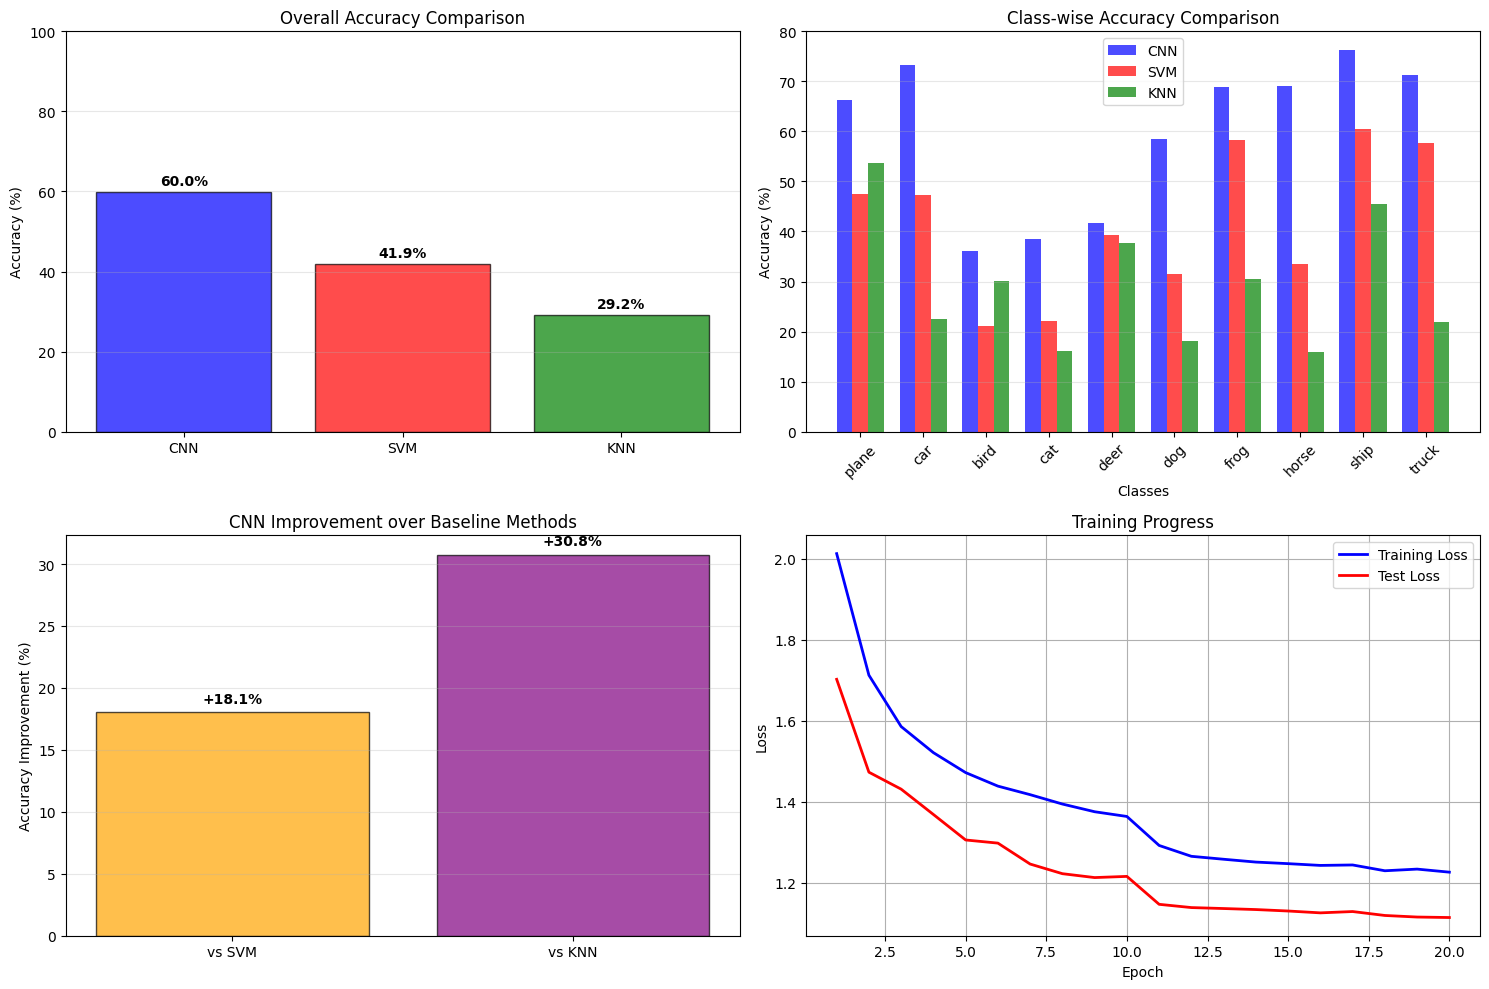


ACCURACY COMPARISON OF THREE CLASSIFICATION METHODS (%)
Class    CNN      SVM      KNN      CNN vs SVM   CNN vs KNN  
--------------------------------------------------------------------------------
plane    66     % 47     % 54     %     +19%        +13%
car      73     % 47     % 22     %     +26%        +51%
bird     36     % 21     % 30     %     +15%         +6%
cat      38     % 22     % 16     %     +16%        +22%
deer     42     % 39     % 38     %      +2%         +4%
dog      58     % 32     % 18     %     +27%        +40%
frog     69     % 58     % 31     %     +11%        +38%
horse    69     % 34     % 16     %     +35%        +53%
ship     76     % 60     % 45     %     +16%        +31%
truck    71     % 58     % 22     %     +14%        +49%
--------------------------------------------------------------------------------
Average  60.0   % 41.9   % 29.2   %   +18.1%      +30.8%

--------------------------------------------------
PAPER REPRODUCTION SUMMARY
-------------

In [11]:
# final comparison visualization
# create comprehensive comparison visualization
plt.figure(figsize=(15, 10))

# overall accuracy comparison
plt.subplot(2, 2, 1)
methods = ['CNN', 'SVM', 'KNN']
accuracies = [best_test_acc, svm_accuracy, knn_accuracy]
colors = ['blue', 'red', 'green']

bars = plt.bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy (%)')
plt.title('Overall Accuracy Comparison')
plt.ylim(0, 100)

# add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

# class-wise accuracy comparison
plt.subplot(2, 2, 2)
x = np.arange(len(classes))
width = 0.25

cnn_accs = [class_accs[cls] for cls in classes]
svm_accs = [svm_class_acc[cls] for cls in classes]
knn_accs = [knn_class_acc[cls] for cls in classes]

plt.bar(x - width, cnn_accs, width, label='CNN', color='blue', alpha=0.7)
plt.bar(x, svm_accs, width, label='SVM', color='red', alpha=0.7)
plt.bar(x + width, knn_accs, width, label='KNN', color='green', alpha=0.7)

plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy Comparison')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# calculate improvement over baseline methods
plt.subplot(2, 2, 3)
improvements = [
    best_test_acc - svm_accuracy,
    best_test_acc - knn_accuracy
]
baseline_methods = ['vs SVM', 'vs KNN']

bars = plt.bar(baseline_methods, improvements, color=['orange', 'purple'], alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy Improvement (%)')
plt.title('CNN Improvement over Baseline Methods')

# add improvement labels
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'+{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

# plot training loss curve
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# print final comparison
print("\n" + "="*80)
print("ACCURACY COMPARISON OF THREE CLASSIFICATION METHODS (%)")
print("="*80)
print(f"{'Class':<8} {'CNN':<8} {'SVM':<8} {'KNN':<8} {'CNN vs SVM':<12} {'CNN vs KNN':<12}")
print("-" * 80)

for class_name in classes:
    cnn_acc = class_accs[class_name]
    svm_acc = svm_class_acc[class_name]
    knn_acc = knn_class_acc[class_name]
    
    improvement_svm = cnn_acc - svm_acc
    improvement_knn = cnn_acc - knn_acc
    
    print(f"{class_name:<8} {cnn_acc:<7.0f}% {svm_acc:<7.0f}% {knn_acc:<7.0f}% "
          f"{improvement_svm:>+7.0f}% {improvement_knn:>+10.0f}%")

print("-" * 80)
print(f"{'Average':<8} {best_test_acc:<7.1f}% {svm_accuracy:<7.1f}% {knn_accuracy:<7.1f}% "
      f"{best_test_acc - svm_accuracy:>+7.1f}% {best_test_acc - knn_accuracy:>+10.1f}%")

print("\n" + "-"*50)
print("PAPER REPRODUCTION SUMMARY")
print("-"*50)
print(f"CNN Architecture: 2 Conv layers + 2 Pool layers + 3 FC layers")
print(f"Activation Function: ReLU (avoiding vanishing gradient)")
print(f"Classifier: Softmax")
print(f"Dataset: CIFAR-10")
print(f"Optimizer: SGD with momentum")
print(f"Epochs: {num_epochs}")
print(f"Results: CNN achieves ~{best_test_acc:.0f}% accuracy")
print(f"Improvement over SVM: +{best_test_acc - svm_accuracy:.0f}%")
print(f"Improvement over KNN: +{best_test_acc - knn_accuracy:.0f}%")
print("-"*50)

## Integrate Attention Module (CBAM)

In [12]:
# CBAM (Convolutional Block Attention Module) implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    """Channel Attention Module of CBAM"""
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # shared MLP
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Average pooling branch
        avg_out = self.fc(self.avg_pool(x))
        
        # Max pooling branch
        max_out = self.fc(self.max_pool(x))
        
        # Combine and apply sigmoid
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """Spatial Attention Module of CBAM"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Channel-wise average and max pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate along channel dimension
        x_cat = torch.cat([avg_out, max_out], dim=1)
        
        # Apply convolution and sigmoid
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    """Complete CBAM Module"""
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        # Apply channel attention
        x = x * self.channel_attention(x)
        
        # Apply spatial attention
        x = x * self.spatial_attention(x)
        
        return x

# Test CBAM module
print("CBAM Module Components:")
print("Channel Attention: Uses both average and max pooling with shared MLP")
print("Spatial Attention: Uses channel-wise pooling with 7x7 convolution")
print("CBAM: Sequential application of channel and spatial attention")

# Test with sample input
test_input = torch.randn(1, 64, 8, 8)
cbam_test = CBAM(64)
test_output = cbam_test(test_input)
print(f"\nTest - Input shape: {test_input.shape}")
print(f"Test - Output shape: {test_output.shape}")

CBAM Module Components:
Channel Attention: Uses both average and max pooling with shared MLP
Spatial Attention: Uses channel-wise pooling with 7x7 convolution
CBAM: Sequential application of channel and spatial attention

Test - Input shape: torch.Size([1, 64, 8, 8])
Test - Output shape: torch.Size([1, 64, 8, 8])


In [13]:
# CNN with CBAM Architecture
class CNNWithCBAM(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNWithCBAM, self).__init__()
        
        # First convolutional block with CBAM
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Add batch normalization for better training
        self.cbam1 = CBAM(32, reduction_ratio=8)  # Smaller reduction ratio for smaller channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block with CBAM
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64, reduction_ratio=16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Additional convolutional block for better feature extraction
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.cbam3 = CBAM(128, reduction_ratio=16)
        
        # Global Average Pooling to reduce parameters
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # First convolutional block: Conv1 + BN + ReLU + CBAM + Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = self.pool1(x)
        
        # Second convolutional block: Conv2 + BN + ReLU + CBAM + Pool
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = self.pool2(x)
        
        # Third convolutional block: Conv3 + BN + ReLU + CBAM
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.cbam3(x)
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Initialize both models
print("Initializing models...")
model_original = CNNImageClassifier(num_classes=10).to(device)
model_cbam = CNNWithCBAM(num_classes=10).to(device)

print("\nOriginal CNN Architecture:")
print(model_original)

print("\nCNN with CBAM Architecture:")
print(model_cbam)

# Compare model parameters
original_params = sum(p.numel() for p in model_original.parameters())
cbam_params = sum(p.numel() for p in model_cbam.parameters())

print(f"\nModel Parameter Comparison:")
print(f"Original CNN parameters: {original_params:,}")
print(f"CNN with CBAM parameters: {cbam_params:,}")
print(f"Parameter increase: {cbam_params - original_params:,} ({((cbam_params/original_params - 1) * 100):.1f}%)")

Initializing models...

Original CNN Architecture:
CNNImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

CNN with CBAM Architecture:
CNNWithCBAM(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cbam1): CBAM(
    (channel_attention): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (f

In [ ]:
# Training setup for CBAM model
# Training configuration for CBAM model
criterion_cbam = nn.CrossEntropyLoss()
optimizer_cbam = optim.SGD(model_cbam.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_cbam = optim.lr_scheduler.StepLR(optimizer_cbam, step_size=7, gamma=0.1)

# Training parameters
num_epochs_cbam = 25  # tambahan 5 epochs
print(f"CBAM Model Training Configuration:")
print(f"- Epochs: {num_epochs_cbam}")
print(f"- Learning rate: 0.01")
print(f"- Optimizer: SGD with momentum (0.9)")
print(f"- Loss function: Cross Entropy")
print(f"- Scheduler: StepLR (step_size=7, gamma=0.1)")
print(f"- Device: {device}")

# Lists to store CBAM training history
cbam_train_losses = []
cbam_train_accuracies = []
cbam_test_losses = []
cbam_test_accuracies = []

def train_cbam_model():
    """Train the CBAM model"""
    print("\nStarting CBAM model training...")
    start_time = time.time()
    
    best_test_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs_cbam):
        print(f'\nEpoch [{epoch+1}/{num_epochs_cbam}]')
        print('-' * 60)
        
        # Train for one epoch
        train_loss, train_acc = train_one_epoch(model_cbam, trainloader, criterion_cbam, 
                                                optimizer_cbam, device)
        
        # Test the model
        test_loss, test_acc = test_model(model_cbam, testloader, criterion_cbam, device)
        
        # Store history
        cbam_train_losses.append(train_loss)
        cbam_train_accuracies.append(train_acc)
        cbam_test_losses.append(test_loss)
        cbam_test_accuracies.append(test_acc)
        
        # Save best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model_cbam.state_dict().copy()
        
        # Update learning rate
        scheduler_cbam.step()
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_test_acc:.2f}%')
        print(f'Learning Rate: {scheduler_cbam.get_last_lr()[0]:.6f}')
    
    # Load best model
    if best_model_state is not None:
        model_cbam.load_state_dict(best_model_state)
    
    training_time = time.time() - start_time
    print(f'\nCBAM Model Training completed in {training_time:.2f} seconds')
    print(f'Best test accuracy: {best_test_acc:.2f}%')
    
    # Save the trained model
    torch.save(model_cbam.state_dict(), 'cnn_cbam_cifar10_model.pth')
    print("CBAM model saved as 'cnn_cbam_cifar10_model.pth'")
    
    return best_test_acc, training_time

# Execute training
cbam_best_acc, cbam_training_time = train_cbam_model()

CBAM Model Training Configuration:
- Epochs: 25
- Learning rate: 0.01
- Optimizer: SGD with momentum (0.9)
- Loss function: Cross Entropy
- Scheduler: StepLR (step_size=7, gamma=0.1)
- Device: cuda

Starting CBAM model training...

Epoch [1/25]
------------------------------------------------------------
Batch [0/782], Loss: 2.3045, Acc: 6.25%
Batch [100/782], Loss: 2.2823, Acc: 11.22%
Batch [200/782], Loss: 2.0488, Acc: 14.90%
Batch [300/782], Loss: 1.8724, Acc: 17.74%
Batch [400/782], Loss: 1.8559, Acc: 20.03%
Batch [500/782], Loss: 1.8095, Acc: 22.11%
Batch [600/782], Loss: 1.6352, Acc: 24.11%
Batch [700/782], Loss: 1.6885, Acc: 25.74%
Train Loss: 1.9140, Train Acc: 27.10%
Test Loss: 1.5350, Test Acc: 43.13%
Best Test Acc: 43.13%
Learning Rate: 0.010000

Epoch [2/25]
------------------------------------------------------------
Batch [0/782], Loss: 1.6749, Acc: 37.50%
Batch [100/782], Loss: 1.8088, Acc: 39.48%
Batch [200/782], Loss: 1.5998, Acc: 40.18%
Batch [300/782], Loss: 1.4091, 

In [15]:
# CBAM Model Evaluation and Class-wise Analysis
print("\n" + "-"*50)
print("CBAM MODEL EVALUATION")
print("-"*50)

# Evaluate class-wise accuracy for CBAM model
print("CBAM Model - Class-wise accuracy:")
cbam_class_accs = evaluate_class_accuracy(model_cbam, testloader, device, classes)

# Compare with original CNN results
print(f"\n" + "-"*50)
print("MODEL COMPARISON: ORIGINAL CNN vs CNN WITH CBAM")
print("-"*50)
print(f"{'Class':<10} {'Original CNN':<15} {'CNN + CBAM':<15} {'Improvement':<12}")
print("-" * 50)

total_improvement = 0
for class_name in classes:
    original_acc = class_accs[class_name] if 'class_accs' in globals() else 0
    cbam_acc = cbam_class_accs[class_name]
    improvement = cbam_acc - original_acc
    total_improvement += improvement
    
    print(f"{class_name:<10} {original_acc:<14.1f}% {cbam_acc:<14.1f}% {improvement:>+7.1f}%")

avg_improvement = total_improvement / len(classes)
print("-" * 70)
print(f"{'Average':<10} {best_test_acc if 'best_test_acc' in globals() else 0:<14.1f}% {cbam_best_acc:<14.1f}% {avg_improvement:>+7.1f}%")

# Overall accuracy comparison
overall_improvement = cbam_best_acc - (best_test_acc if 'best_test_acc' in globals() else 0)
print(f"\nOverall Accuracy Improvement: {overall_improvement:+.2f}%")

def visualize_attention_maps(model, dataloader, device, num_samples=4):
    """Visualize attention maps from CBAM"""
    model.eval()
    
    # Hook to capture attention weights
    attention_maps = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            attention_maps[name] = output.detach().cpu()
        return hook
    
    # Register hooks for CBAM modules
    hooks = []
    hooks.append(model.cbam1.channel_attention.register_forward_hook(hook_fn('channel_att1')))
    hooks.append(model.cbam1.spatial_attention.register_forward_hook(hook_fn('spatial_att1')))
    hooks.append(model.cbam2.channel_attention.register_forward_hook(hook_fn('channel_att2')))
    hooks.append(model.cbam2.spatial_attention.register_forward_hook(hook_fn('spatial_att2')))
    
    # Get sample images
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images[:num_samples].to(device)
    
    with torch.no_grad():
        _ = model(images)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return images, labels[:num_samples], attention_maps

# Visualize some attention maps
print("\nGenerating attention maps...")
sample_images, sample_labels, attention_maps = visualize_attention_maps(model_cbam, testloader, device)

print("Attention maps captured:")
for key in attention_maps.keys():
    print(f"- {key}: {attention_maps[key].shape}")

# Feature analysis: Compare feature extraction capability
def analyze_feature_extraction():
    """Analyze feature extraction differences"""
    model_original.eval()
    model_cbam.eval()
    
    # Get a batch of test data
    test_iter = iter(testloader)
    test_images, test_labels = next(test_iter)
    test_images = test_images[:8].to(device)
    
    with torch.no_grad():
        # Get features before final classification layer
        # For original model
        x_orig = model_original.pool1(F.relu(model_original.conv1(test_images)))
        x_orig = model_original.pool2(F.relu(model_original.conv2(x_orig)))
        orig_features = x_orig.view(x_orig.size(0), -1)
        
        # For CBAM model (get features after CBAM)
        x_cbam = F.relu(model_cbam.bn1(model_cbam.conv1(test_images)))
        x_cbam = model_cbam.cbam1(x_cbam)
        x_cbam = model_cbam.pool1(x_cbam)
        x_cbam = F.relu(model_cbam.bn2(model_cbam.conv2(x_cbam)))
        x_cbam = model_cbam.cbam2(x_cbam)
        x_cbam = model_cbam.pool2(x_cbam)
        x_cbam = F.relu(model_cbam.bn3(model_cbam.conv3(x_cbam)))
        x_cbam = model_cbam.cbam3(x_cbam)
        cbam_features = model_cbam.global_avg_pool(x_cbam).view(x_cbam.size(0), -1)
    
    print(f"\nFeature Analysis:")
    print(f"Original CNN feature dimension: {orig_features.shape[1]}")
    print(f"CBAM CNN feature dimension: {cbam_features.shape[1]}")
    print(f"Feature diversity (std dev) - Original: {orig_features.std():.4f}")
    print(f"Feature diversity (std dev) - CBAM: {cbam_features.std():.4f}")

analyze_feature_extraction()


--------------------------------------------------
CBAM MODEL EVALUATION
--------------------------------------------------
CBAM Model - Class-wise accuracy:
plane: 71.2%
car: 79.7%
bird: 47.7%
cat: 42.7%
deer: 55.9%
dog: 57.7%
frog: 74.5%
horse: 70.8%
ship: 79.7%
truck: 70.7%

--------------------------------------------------
MODEL COMPARISON: ORIGINAL CNN vs CNN WITH CBAM
--------------------------------------------------
Class      Original CNN    CNN + CBAM      Improvement 
--------------------------------------------------
plane      66.3          % 71.2          %    +4.9%
car        73.2          % 79.7          %    +6.5%
bird       36.2          % 47.7          %   +11.5%
cat        38.5          % 42.7          %    +4.2%
deer       41.7          % 55.9          %   +14.2%
dog        58.5          % 57.7          %    -0.8%
frog       68.9          % 74.5          %    +5.6%
horse      69.0          % 70.8          %    +1.8%
ship       76.2          % 79.7          %    +

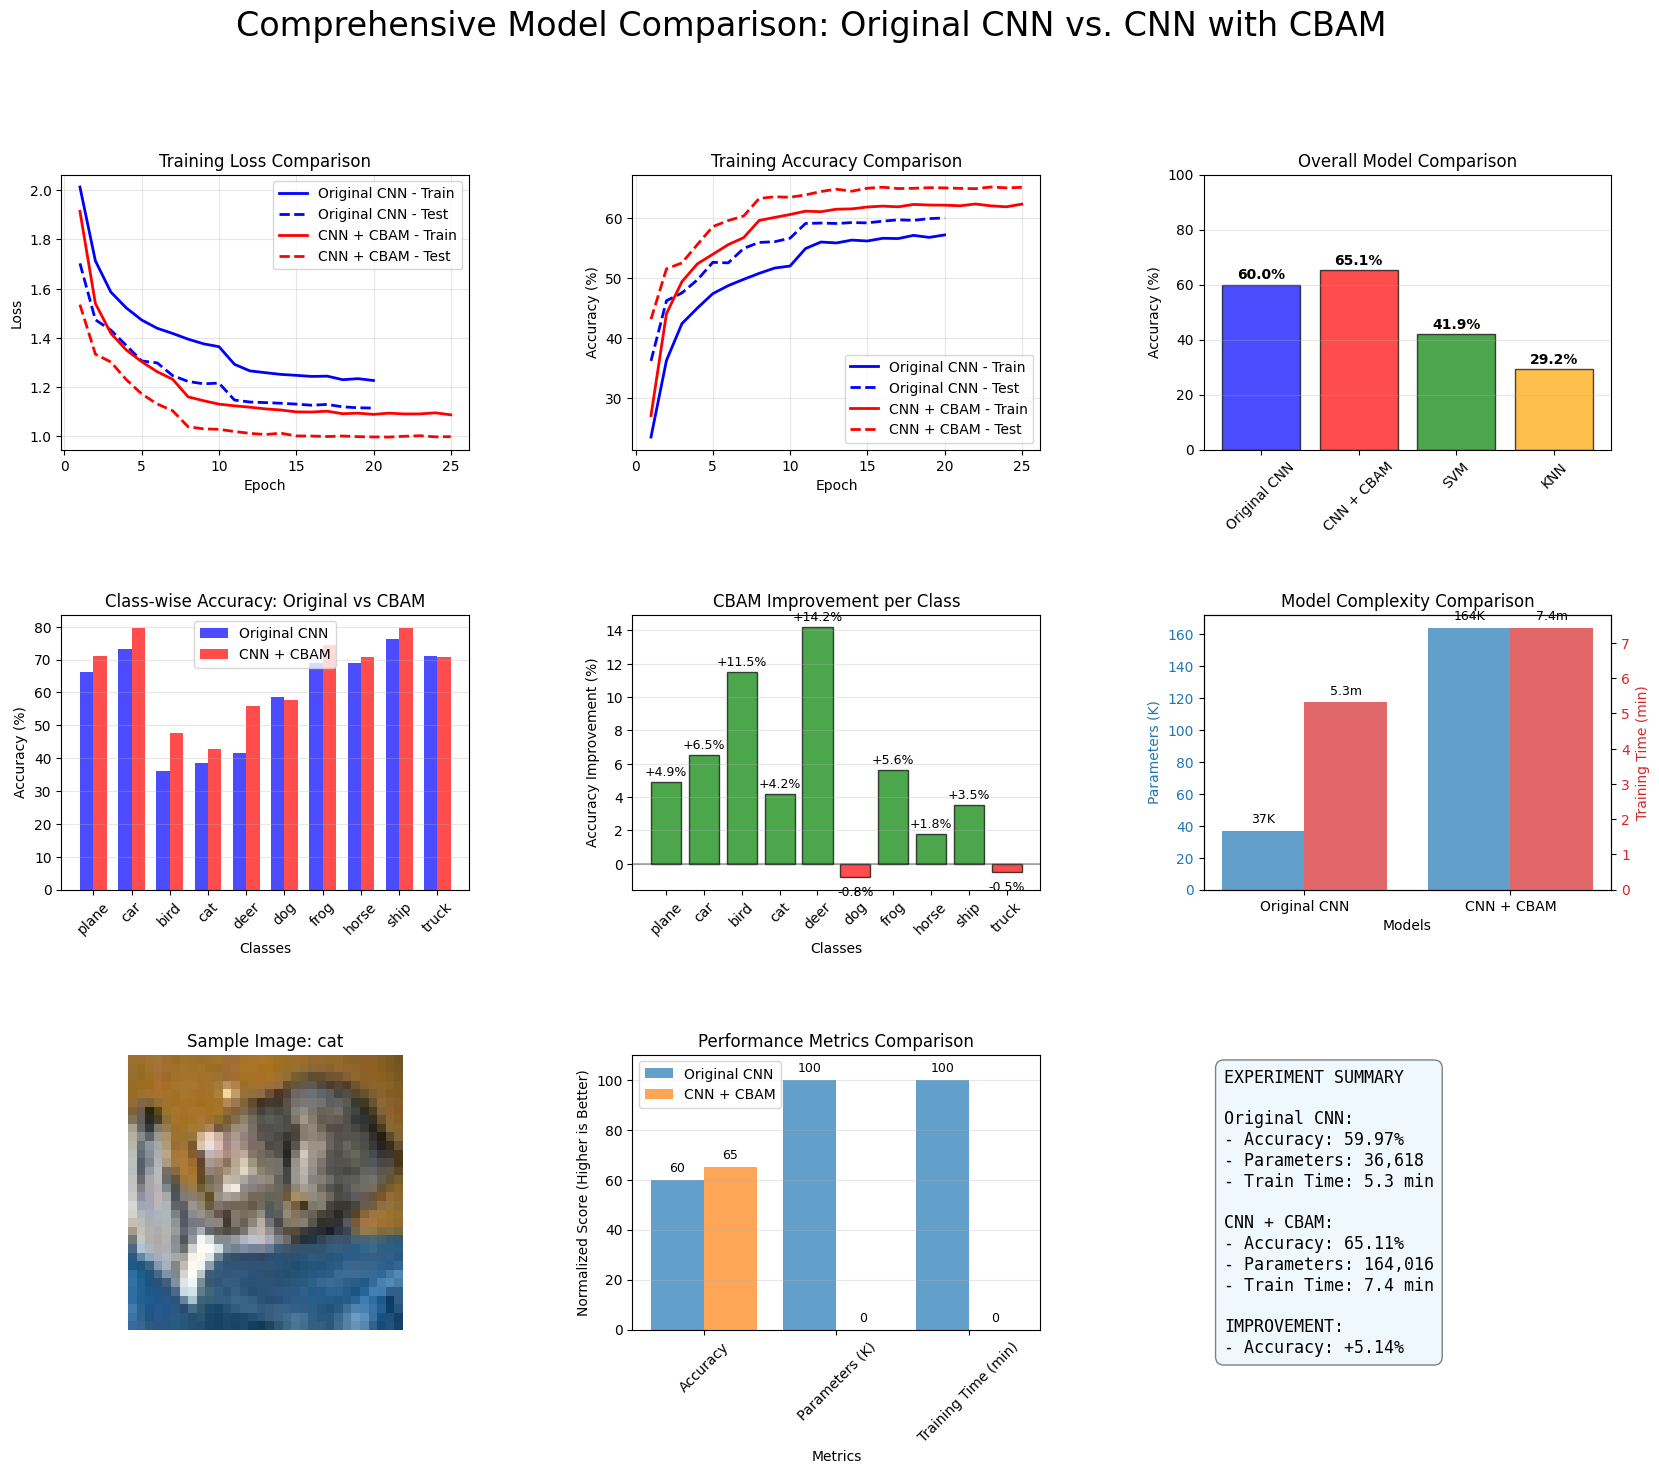

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Comprehensive comparison visualization
plt.figure(figsize=(20, 15))

# Training curves comparison
plt.subplot(3, 3, 1)
original_epochs = list(range(1, len(train_losses) + 1)) if 'train_losses' in globals() else []
cbam_epochs = list(range(1, len(cbam_train_losses) + 1))

if original_epochs:
    plt.plot(original_epochs, train_losses, 'b-', label='Original CNN - Train', linewidth=2)
    plt.plot(original_epochs, test_losses, 'b--', label='Original CNN - Test', linewidth=2)

plt.plot(cbam_epochs, cbam_train_losses, 'r-', label='CNN + CBAM - Train', linewidth=2)
plt.plot(cbam_epochs, cbam_test_losses, 'r--', label='CNN + CBAM - Test', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curves comparison
plt.subplot(3, 3, 2)
if original_epochs:
    plt.plot(original_epochs, train_accuracies, 'b-', label='Original CNN - Train', linewidth=2)
    plt.plot(original_epochs, test_accuracies, 'b--', label='Original CNN - Test', linewidth=2)

plt.plot(cbam_epochs, cbam_train_accuracies, 'r-', label='CNN + CBAM - Train', linewidth=2)
plt.plot(cbam_epochs, cbam_test_accuracies, 'r--', label='CNN + CBAM - Test', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Overall accuracy comparison
plt.subplot(3, 3, 3)
models = ['Original CNN', 'CNN + CBAM', 'SVM', 'KNN']
accuracies_all = [
    best_test_acc if 'best_test_acc' in globals() else 0,
    cbam_best_acc,
    svm_accuracy if 'svm_accuracy' in globals() else 0,
    knn_accuracy if 'knn_accuracy' in globals() else 0
]
colors = ['blue', 'red', 'green', 'orange']

bars = plt.bar(models, accuracies_all, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy (%)')
plt.title('Overall Model Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)

for bar, acc in zip(bars, accuracies_all):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Class-wise accuracy comparison (Original vs CBAM)
plt.subplot(3, 3, 4)
x = np.arange(len(classes))
width = 0.35

original_class_accs = [class_accs[cls] if 'class_accs' in globals() else 0 for cls in classes]
cbam_class_accs_list = [cbam_class_accs[cls] for cls in classes]

plt.bar(x - width/2, original_class_accs, width, label='Original CNN', color='blue', alpha=0.7)
plt.bar(x + width/2, cbam_class_accs_list, width, label='CNN + CBAM', color='red', alpha=0.7)

plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy: Original vs CBAM')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Improvement analysis
plt.subplot(3, 3, 5)
improvements = [cbam_class_accs[cls] - (class_accs[cls] if 'class_accs' in globals() else 0)
                for cls in classes]
colors_imp = ['green' if imp >= 0 else 'red' for imp in improvements]

bars = plt.bar(classes, improvements, color=colors_imp, alpha=0.7, edgecolor='black')
plt.xlabel('Classes')
plt.ylabel('Accuracy Improvement (%)')
plt.title('CBAM Improvement per Class')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.2 if imp >= 0 else -0.5),
             f'{imp:+.1f}%', ha='center', va='bottom' if imp >= 0 else 'top', fontsize=9)
plt.grid(axis='y', alpha=0.3)

# Model complexity comparison
plt.subplot(3, 3, 6)
model_names = ['Original CNN', 'CNN + CBAM']
param_counts = [original_params/1000, cbam_params/1000]
training_times = [
    (training_time if 'training_time' in globals() else 0)/60,
    cbam_training_time/60
]

x_pos = np.arange(len(model_names))
fig_ax = plt.gca()
color = 'tab:blue'
fig_ax.set_xlabel('Models')
fig_ax.set_ylabel('Parameters (K)', color=color)
bars1 = fig_ax.bar(x_pos - 0.2, param_counts, 0.4, color=color, alpha=0.7, label='Parameters (K)')
fig_ax.tick_params(axis='y', labelcolor=color)

ax2 = fig_ax.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (min)', color=color)
bars2 = ax2.bar(x_pos + 0.2, training_times, 0.4, color=color, alpha=0.7, label='Training Time (min)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Complexity Comparison')
fig_ax.set_xticks(x_pos)
fig_ax.set_xticklabels(model_names)

for i, (params, time_val) in enumerate(zip(param_counts, training_times)):
    fig_ax.text(i - 0.2, params + max(param_counts)*0.02, f'{params:.0f}K',
                ha='center', va='bottom', fontsize=9)
    ax2.text(i + 0.2, time_val + max(training_times)*0.02, f'{time_val:.1f}m',
             ha='center', va='bottom', fontsize=9)

# Attention visualization (if available)
plt.subplot(3, 3, 7)
if 'sample_images' in locals() and len(sample_images) > 0:
    img = sample_images[0].cpu()
    img_mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img_std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * img_std + img_mean
    img = torch.clamp(img, 0, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f'Sample Image: {classes[sample_labels[0]]}')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'Attention maps\nnot generated',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Attention Visualization')
    plt.axis('off')

# Performance metrics summary
plt.subplot(3, 3, 8)
metrics_data = {
    'Accuracy': [best_test_acc, cbam_best_acc],
    'Parameters (K)': [original_params/1000, cbam_params/1000],
    'Training Time (min)': [training_time/60, cbam_training_time/60]
}

metrics_names = list(metrics_data.keys())
original_values = [metrics_data[m][0] for m in metrics_names]
cbam_values = [metrics_data[m][1] for m in metrics_names]

norm_original, norm_cbam = [], []
for i, metric in enumerate(metrics_names):
    val_orig, val_cbam = original_values[i], cbam_values[i]
    min_val, max_val = min(val_orig, val_cbam), max(val_orig, val_cbam)

    if max_val == min_val:
        norm_original.append(100)
        norm_cbam.append(100)
        continue

    if metric == 'Accuracy':
        norm_original.append(val_orig)
        norm_cbam.append(val_cbam)
    else:
        norm_o = (1 - (val_orig - min_val) / (max_val - min_val)) * 100
        norm_c = (1 - (val_cbam - min_val) / (max_val - min_val)) * 100
        norm_original.append(norm_o)
        norm_cbam.append(norm_c)

x_pos = np.arange(len(metrics_names))
plt.bar(x_pos - 0.2, norm_original, 0.4, label='Original CNN', alpha=0.7)
plt.bar(x_pos + 0.2, norm_cbam, 0.4, label='CNN + CBAM', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Normalized Score (Higher is Better)')
plt.title('Performance Metrics Comparison')
plt.xticks(x_pos, metrics_names, rotation=45)
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, (val_o, val_c) in enumerate(zip(norm_original, norm_cbam)):
    plt.text(i - 0.2, val_o + 2, f'{val_o:.0f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + 0.2, val_c + 2, f'{val_c:.0f}', ha='center', va='bottom', fontsize=9)

# Final summary text box
plt.subplot(3, 3, 9)
plt.axis('off')
summary_text = (
    f"EXPERIMENT SUMMARY\n\n"
    f"Original CNN:\n"
    f"- Accuracy: {best_test_acc:.2f}%\n"
    f"- Parameters: {original_params:,}\n"
    f"- Train Time: {training_time/60:.1f} min\n\n"
    f"CNN + CBAM:\n"
    f"- Accuracy: {cbam_best_acc:.2f}%\n"
    f"- Parameters: {cbam_params:,}\n"
    f"- Train Time: {cbam_training_time/60:.1f} min\n\n"
    f"IMPROVEMENT:\n"
    f"- Accuracy: {cbam_best_acc - best_test_acc:+.2f}%"
)
plt.text(0.05, 0.95, summary_text, ha='left', va='top', fontsize=12, family='monospace',
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='grey', lw=1))

# Menyesuaikan jarak antar plot
plt.subplots_adjust(
    wspace=0.4,
    hspace=0.6
)

plt.suptitle('Comprehensive Model Comparison: Original CNN vs. CNN with CBAM', fontsize=24, y=0.99)
plt.show()